In [13]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Final data cleaning will be done using Spreadsheets - faster and easier to visualize. 
The steps taken were: 

* Normalizing the spelling of each neighborhood to match with the nyc_df.csv file
* Changing neighborhood of locations that don't have the correct neighborhood

In [4]:
# Use merge df that has no duplicates
df = pd.read_csv('/home/eduardo/nyc-neighborhoods/data//nyc_health_borough.csv', )
df.drop('Unnamed: 0', axis=1, inplace=True)
df

,Venue,Category,Latitude_x,Longitude_x,Neighborhood,ZIP,Borough,Longitude_y,Latitude_y
0,Wakefield Eye Care,Optometrist,40.898682,-73.849352,Wakefield,10466,Bronx,-73.847201,40.894705
1,Advanced Dental Group,Dentist,40.875278,-73.828492,Co-op City,10475,Bronx,-73.829939,40.874294
2,Creating Smiles,Dentist,40.871558,-73.830285,Co-op City,10475,Bronx,-73.829939,40.874294
3,NYC Health & Hospitals,Medical Center,40.873701,-73.826771,Co-op City,10475,Bronx,-73.829939,40.874294
4,Montefiore Medical Group,Physician,40.877116,-73.828470,Co-op City,10475,Bronx,-73.829939,40.874294
...,...,...,...,...,...,...,...,...,...
5859,Staten Island Dental Arts Center,Dentist,40.529627,-74.202826,Prince's Bay,10309,Staten Island,-74.201526,40.526264
5860,Arverne Dental,Dentist,40.587008,-73.811274,Hammels,11693,Queens,-73.805530,40.587338
5861,Beach Ny Physical Ther,Physical Therapy Clinic,40.587227,-73.811108,Hammels,11693,Queens,-73.805530,40.587338
5862,Heritage Adult Care,Healthcare Clinic,40.587227,-73.811108,Hammels,11693,Queens,-73.805530,40.587338


In [5]:
# How many neighborhoods are there? 
df['Neighborhood'].nunique()

227

In [6]:
df_2d = df.groupby('Neighborhood').count().drop([
    'Category', 'Latitude_x', 'Longitude_x', 'ZIP', 'Borough', 'Longitude_y', 'Latitude_y'], axis=1)

In [7]:
df_2d.head(5)

,Venue
Neighborhood,
Allerton,17
Annadale,4
Arden Heights,4
Arlington,1
Arrochar,7


In [8]:
# import Kmeans 
from sklearn.cluster import KMeans
# import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

In [9]:
# Instantiate the scaler
scaler = MinMaxScaler()
 
# Create a scaled data frame
scaled_data = scaler.fit_transform(df_2d.to_numpy())
df_scaled = pd.DataFrame(scaled_data)
df_scaled.columns = ['Venue count']

In [10]:
df_scaled.head(3)

,Venue count
0,0.092486
1,0.017341
2,0.017341


In [14]:
def plot_distortion(df_scaled,max_clusters = 10):
    distortions = []
    for i in range(1, max_clusters +1):
        km = KMeans(n_clusters=i,
                    init='k-means++',
                    n_init=10,
                    random_state=0)
        km.fit(df_scaled)
        distortions.append(km.inertia_)

    plt.plot(range(1,max_clusters +1), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show()

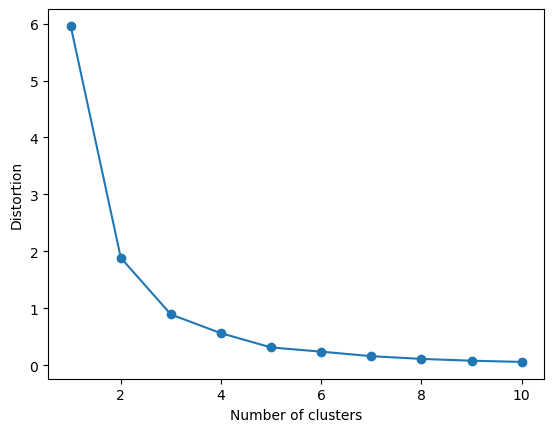

In [15]:
plot_distortion(np.array(df_scaled),max_clusters=10)

From the plot above, we could use 3 clusters

In [16]:
# Instantiate KMeans
km = KMeans(n_clusters=3, # clusters we expected 
            n_init=15, # initial runs
            random_state=0)

In [17]:
# Fit our data to the model
y_km = km.fit_predict(df_scaled)

In [20]:
def plot_clusters(X,y_res, plt_cluster_centers = False):
    X_centroids = []
    Y_centroids = []

    for cluster in set(y_res):
        x = X[y_res == cluster,0]
        y = X[y_res == cluster,0] # Changed to 0 because data is 1D
        X_centroids.append(np.mean(x))
        Y_centroids.append(np.mean(y))

        plt.scatter(x,
                    y,
                    s=50,
                    marker='s',
                    label=f'cluster {cluster}')

    if plt_cluster_centers:
        plt.scatter(X_centroids,
                    Y_centroids,
                    marker='*',
                    c='red',
                    s=250,
                    label='centroids')
    plt.legend()
    plt.grid()
    plt.show()

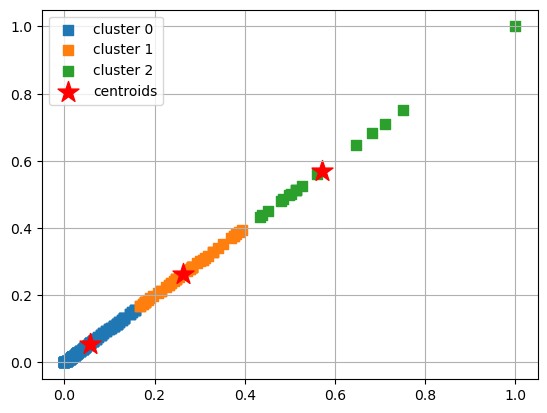

In [21]:
plot_clusters(df_scaled.to_numpy(), y_km, plt_cluster_centers= True)

We can see that it works, but we should add more features to get more significant clustering.

## Clustering with additional features

In [26]:
# Test code to get top entries from value_counts()
test = list(df['Neighborhood'].value_counts()[:3].index)
test.append(0)
test

['Chinatown', 'East Village', 'Lenox Hill', 0]

In [125]:
# Get a list with all unique neighborhoods
# We will use this as a filter in a for loop
hood_list = df['Neighborhood'].unique()

In [110]:
my_dict = {}

# This loop will iterate over each neighborhood and add
# the top category types for each
for hood in hood_list:
    #print(hood)
    df_filter = df[df['Neighborhood'] == hood]
    #print(df_filter['Category'].value_counts())
        
    if len(list(df_filter['Category'].value_counts()[:3].index)) == 3:
        my_dict[hood] = list(df_filter['Category'].value_counts()[:3].index)
    
    elif len(list(df_filter['Category'].value_counts()[:3].index)) == 2:
        to_list = list(df_filter['Category'].value_counts()[:3].index)
        #print(to_list)
        to_list.append(0)
        my_dict[hood] = to_list
        
    else: 
        to_list = list(df_filter['Category'].value_counts()[:3].index)
        #print(to_list)
        to_list.append(0)
        to_list.append(0)
        my_dict[hood] = to_list

In [111]:
# Check if for loop works properly
my_dict

{'Wakefield': ['Optometrist', 0, 0],
 'Co-op City': ['Dentist', 'Health and Medicine', 'Physical Therapy Clinic'],
 'Fieldston': ['Dentist', 'Health and Medicine', 'Nutritionist'],
 'Riverdale': ['Health and Medicine', 'Dentist', "Doctor's Office"],
 'Kingsbridge': ['Health and Medicine', 'Dentist', 'Physical Therapy Clinic'],
 'Inwood': ['Dentist', 'Health and Medicine', 'Hospital'],
 'Marble Hill': ['Dentist',
  'Physical Therapy Clinic',
  'Assisted Living Service'],
 'Kingsbridge Heights': ['Home Health Care Service',
  'Hospital',
  'Health and Medicine'],
 'Woodlawn': ['Medical Lab', 'Emergency Room', "Doctor's Office"],
 'Norwood': ['Health and Medicine', 'Dentist', "Doctor's Office"],
 'Williamsbridge': ['Dentist', 0, 0],
 'Baychester': ['Healthcare Clinic', 'Assisted Living Service', 0],
 'Pelham Parkway': ['Dentist', "Doctor's Office", 'Ophthalmologist'],
 'Allerton': ['Chiropractor', 'Dentist', 'Nutritionist'],
 'City Island': ["Doctor's Office", 'Physical Therapy Clinic', 0

In [133]:
# Build our beautiful df 
top_venues = pd.DataFrame(data=my_dict).T
top_venues.columns = ['1st', '2nd', '3rd']
top_venues

,1st,2nd,3rd
Wakefield,Optometrist,0,0
Co-op City,Dentist,Health and Medicine,Physical Therapy Clinic
Fieldston,Dentist,Health and Medicine,Nutritionist
Riverdale,Health and Medicine,Dentist,Doctor's Office
Kingsbridge,Health and Medicine,Dentist,Physical Therapy Clinic
...,...,...,...
Manor Heights,Assisted Living Service,Health and Medicine,0
Egbertville,Nursing Home,Nutritionist,Hospice
Prince's Bay,Dentist,Internal Medicine Doctor,Doctor's Office
Hammels,Dentist,Physical Therapy Clinic,Healthcare Clinic


In [52]:
# Now, we need to label each category with a number 
# We could either assign ordinal values, or get dummies

In [53]:
# How many unique categories are there? 
df.Category.nunique()

57

In [76]:
# Not working, remove for now:
# Import OrdinalEncoder from sklearn
#from sklearn.preprocessing import OrdinalEncoder

# category ordering 
#oe = OrdinalEncoder(categories=cat_list)

In [101]:
# Create an ordered list with unique categories
cat_list = list(df['Category'].value_counts(ascending=True).index)
cat_list

['Respiratory Doctor',
 'AIDS Resource',
 'Geriatric Doctor',
 'Weight Loss Center',
 'Blood Bank',
 'Oral Surgeon',
 'Rehabilitation Center',
 'Hospice',
 'Urologist',
 'Other Healthcare Professional',
 'Pathologist',
 'Anesthesiologist',
 'Maternity Clinic',
 'Gastroenterologist',
 'Oncologist',
 'Sports Medicine Clinic',
 'Emergency Room',
 'Emergency Service',
 'Radiologist',
 'Cardiologist',
 'Ear, Nose and Throat Doctor',
 'Alternative Medicine Clinic',
 'Ambulance Service',
 'Obstetrician Gynecologist (Ob-gyn)',
 'Neurologist',
 'Orthopedic Surgeon',
 'Plastic Surgeon',
 'Psychiatrist',
 'Psychologist',
 'Family Medicine Doctor',
 'Urgent Care Center',
 'Internal Medicine Doctor',
 'Nursing Home',
 'Medical Lab',
 'General Surgeon',
 'Nurse',
 'Assisted Living Service',
 'Dermatologist',
 'Nutritionist',
 'Mental Health Service',
 'Pediatrician',
 'Home Health Care Service',
 'Mental Health Clinic',
 'Acupuncture Clinic',
 'Podiatrist',
 'Ophthalmologist',
 'Chiropractor',
 'Hea

In [109]:
# Create a list with the numbers that will replace each category
cat_encode = list(range(1, len(cat_list)+1))
cat_encode

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57]

In [127]:
# Create a dict with the categories as keys, and encoding as values
enc_dict = dict(zip(cat_list, cat_encode))
enc_dict

{'Respiratory Doctor': 1,
 'AIDS Resource': 2,
 'Geriatric Doctor': 3,
 'Weight Loss Center': 4,
 'Blood Bank': 5,
 'Oral Surgeon': 6,
 'Rehabilitation Center': 7,
 'Hospice': 8,
 'Urologist': 9,
 'Other Healthcare Professional': 10,
 'Pathologist': 11,
 'Anesthesiologist': 12,
 'Maternity Clinic': 13,
 'Gastroenterologist': 14,
 'Oncologist': 15,
 'Sports Medicine Clinic': 16,
 'Emergency Room': 17,
 'Emergency Service': 18,
 'Radiologist': 19,
 'Cardiologist': 20,
 'Ear, Nose and Throat Doctor': 21,
 'Alternative Medicine Clinic': 22,
 'Ambulance Service': 23,
 'Obstetrician Gynecologist (Ob-gyn)': 24,
 'Neurologist': 25,
 'Orthopedic Surgeon': 26,
 'Plastic Surgeon': 27,
 'Psychiatrist': 28,
 'Psychologist': 29,
 'Family Medicine Doctor': 30,
 'Urgent Care Center': 31,
 'Internal Medicine Doctor': 32,
 'Nursing Home': 33,
 'Medical Lab': 34,
 'General Surgeon': 35,
 'Nurse': 36,
 'Assisted Living Service': 37,
 'Dermatologist': 38,
 'Nutritionist': 39,
 'Mental Health Service': 40,


In [134]:
# Now map the top_venues dataframe to get corresponding number
# for each category
##### ONLY RUN THIS CELL ONCE #####
top_venues['1st'] = top_venues['1st'].map(enc_dict)
top_venues['2nd'] = top_venues['2nd'].map(enc_dict)
top_venues['3rd'] = top_venues['3rd'].map(enc_dict)

In [174]:
# Fill NaNs with 0
top_venues = top_venues.fillna(0)
top_venues.head(3)

,1st,2nd,3rd
Wakefield,51,0.0,0.0
Co-op City,57,56.0,53.0
Fieldston,57,56.0,39.0


In [175]:
# Instantiate the scaler
scaler = MinMaxScaler()
 
# Create a scaled data frame
scaled_venue_count = scaler.fit_transform(top_venues.to_numpy())
tv_scaled = pd.DataFrame(scaled_venue_count)
tv_scaled.columns = [['1st', '2nd', '3rd']]

In [176]:
tv_scaled.head(3)

,1st,2nd,3rd
0,0.863636,0.000000,0.000000
1,1.000000,0.982456,0.929825
2,1.000000,0.982456,0.684211


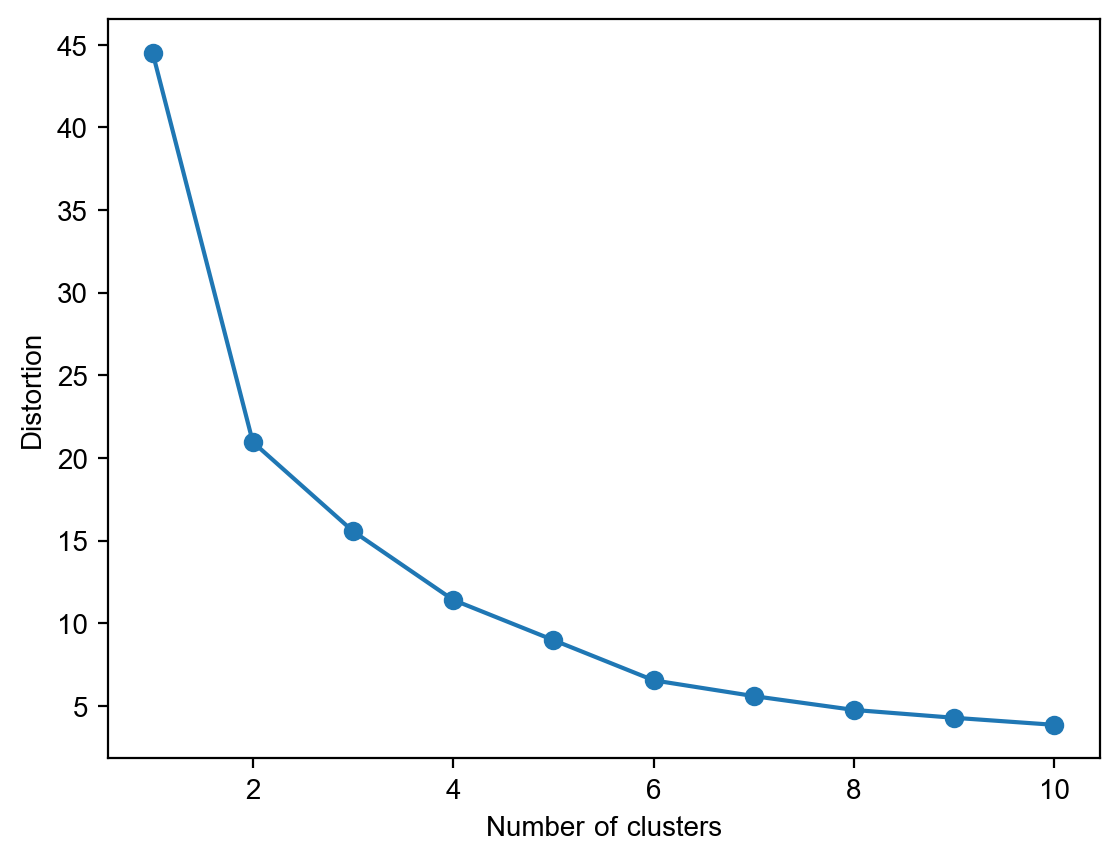

In [145]:
# Get the inertia 
plot_distortion(np.array(tv_scaled),max_clusters=10)

In [150]:
# Instantiate KMeans
km_v = KMeans(n_clusters=3, # clusters we expected 
            n_init=15, # initial runs
            random_state=0)

In [151]:
# Fit our data to the model
tv_km = km_v.fit_predict(tv_scaled)

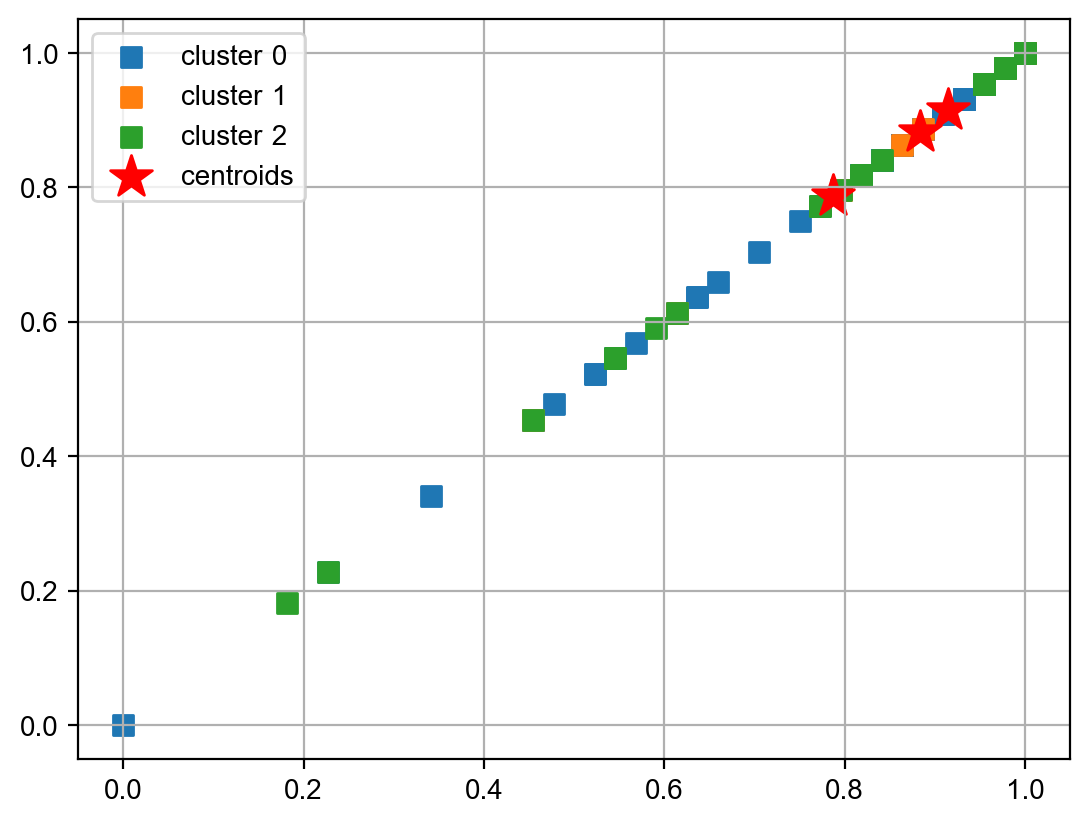

In [152]:
plot_clusters(tv_scaled.to_numpy(), tv_km, plt_cluster_centers= True)

# Hierarchichal

In [180]:
# import Agglomerative clustering
from sklearn.cluster import AgglomerativeClustering

# import scipy.cluster.hierarchy
import scipy.cluster.hierarchy as sch

In [177]:
# Use the scaled top venues df from the previous step
tv_2feat = tv_scaled.drop('3rd', axis=1)
tv_2feat

,1st,2nd
0,0.863636,0.000000
1,1.000000,0.982456
2,1.000000,0.982456
3,0.977273,1.000000
4,0.977273,1.000000
...,...,...
222,0.545455,0.982456
223,0.454545,0.684211
224,1.000000,0.561404
225,1.000000,0.929825


In [178]:
# Define function plot_dendrogram
def plot_dendrogram(X, method='ward'):
    # create dendrogram using sch
    dendrogram = sch.dendrogram(sch.linkage(X, method=method))
    
    # add features
    plt.title('Dendrogram')
    plt.ylabel('Euclidean Distances')
    plt.xlabel('Points')
    plt.show()   

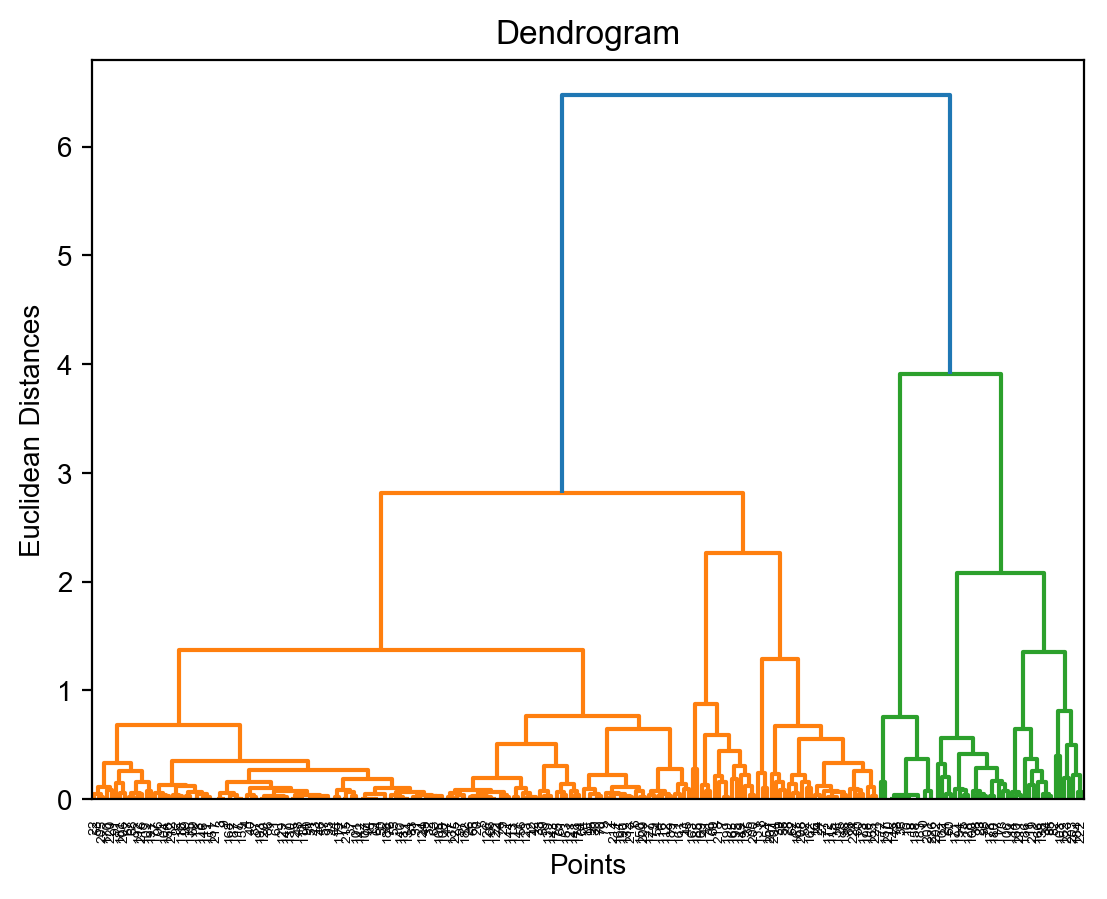

In [184]:
# Plot dendrogram
plot_dendrogram(tv_scaled)

# Visualizations

In [84]:
# Import plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from IPython.display import set_matplotlib_formats
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina', quality=100)
import matplotlib
plt.rcParams["font.family"] = "garuda" # check available fonts below

In [85]:
# Visualize the available fonts
import matplotlib.font_manager
from IPython.core.display import HTML

def make_html(fontname):
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

HTML("<div style='column-count: 2;'>{}</div>".format(code))

In [86]:
# Count number of venues 
cat_count = df['Category'].value_counts()

In [98]:
cat_count.sum()

5864

Preliminary plot of most common venues

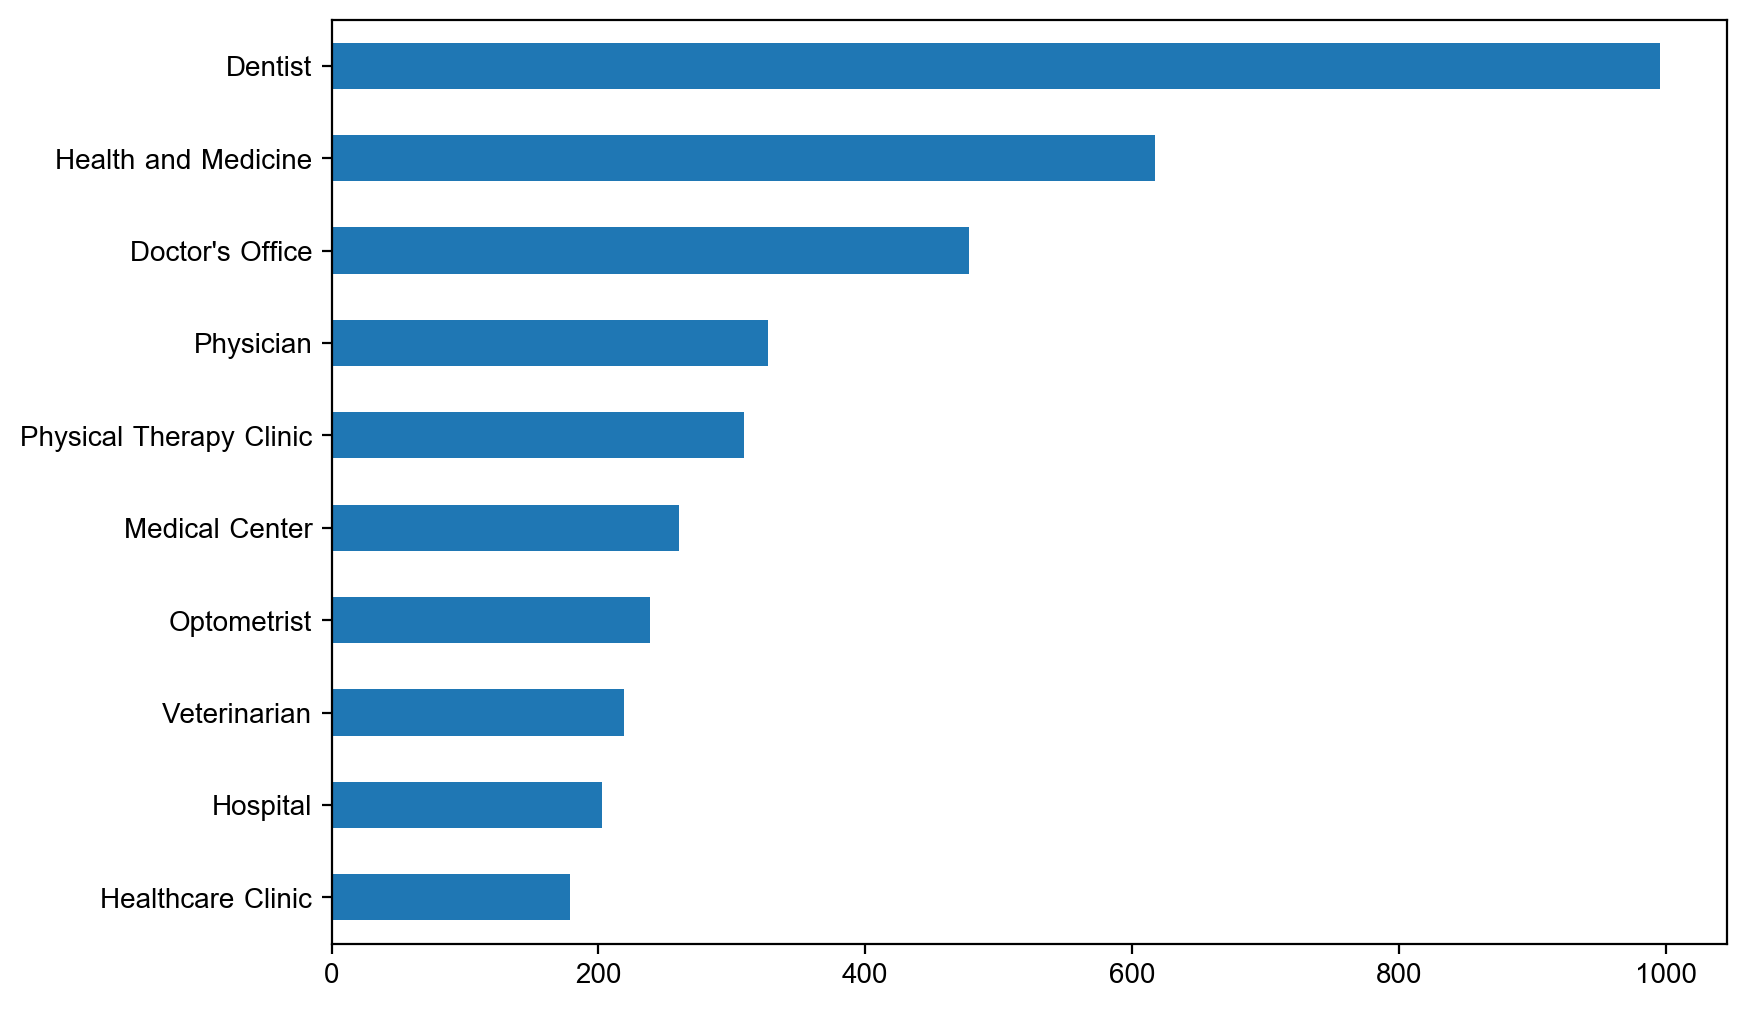

In [88]:
# Initialize fig and axes objects 
f, ax = plt.subplots(figsize=(9,6))

# Plot total number of venues
ax = cat_count.head(10).plot(kind='barh');
ax.invert_yaxis()

# Make the chart fill out the figure better.
#f.tight_layout()
plt.show()

Formatted plot of most common venues

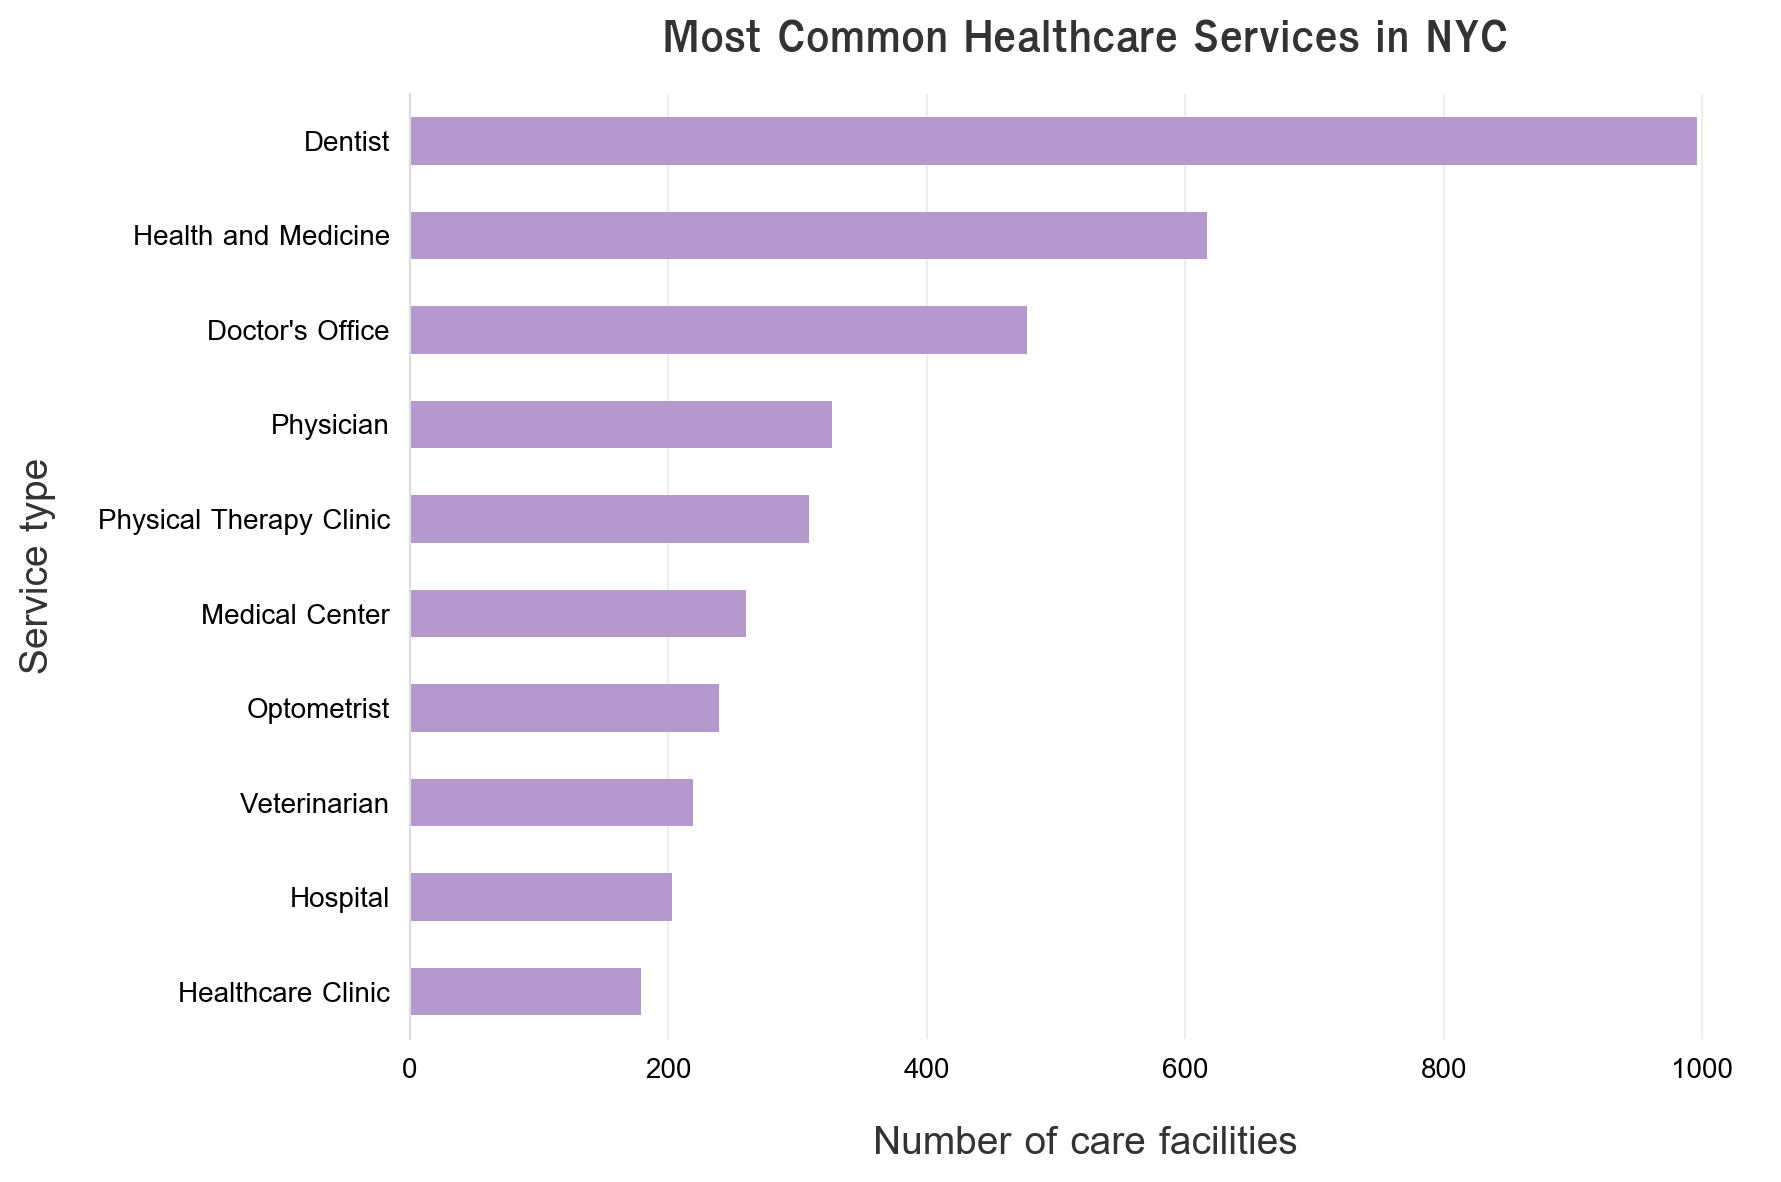

In [163]:
# Initialize fig and axes objects 
f, ax = plt.subplots(figsize=(9,6))

# Plot total number of venues
ax = cat_count.head(10).plot(kind='barh', color=(0.7, 0.6, 0.8, 1))
ax.invert_yaxis()

# Remove top, right and left spines (borders)
# Also, make the bottom spine gray instead of black.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#DDDDDD')
ax.spines['bottom'].set_visible(False)

# Remove axis ticks
ax.tick_params(bottom=False, left=False)

# Keep the horizontal grid hidden.
# Color the vertical lines as light gray.
ax.set_axisbelow(True)
ax.yaxis.grid(False)
ax.xaxis.grid(True, color='#EEEEEE')

# Add labels and a title. 
ax.set_xlabel('Number of care facilities', labelpad=15, color='#333333', fontname='garuda', fontsize=14)
ax.set_ylabel('Service type', labelpad=15, color='#333333', fontname='garuda', fontsize=14)
ax.set_title('Most Common Healthcare Services in NYC',loc='center', pad=15, color='#333333',
             weight='bold', fontname='garuda', fontsize=16)

# Make the chart fill out the figure better.
f.tight_layout()
#f.savefig('most-common-ven-nyc.png', dpi=300)

Which neighborhoods have more access to healthcare facilities?

In [110]:
df.head()

,Venue,Category,Latitude_x,Longitude_x,Neighborhood,ZIP,Borough,Longitude_y,Latitude_y
0,Wakefield Eye Care,Optometrist,40.898682,-73.849352,Wakefield,10466,Bronx,-73.847201,40.894705
1,Advanced Dental Group,Dentist,40.875278,-73.828492,Co-op City,10475,Bronx,-73.829939,40.874294
2,Creating Smiles,Dentist,40.871558,-73.830285,Co-op City,10475,Bronx,-73.829939,40.874294
3,NYC Health & Hospitals,Medical Center,40.873701,-73.826771,Co-op City,10475,Bronx,-73.829939,40.874294
4,Montefiore Medical Group,Physician,40.877116,-73.828470,Co-op City,10475,Bronx,-73.829939,40.874294


In [83]:
# Write code to select neighborhoods have the most entries
# Then plot in a bar chart
most_venues = df.groupby('Neighborhood').agg(
    n_venues=('Venue', 'count')).sort_values('n_venues', ascending=False)

# show neighborhoods with most venues
most_venues

,n_venues
Neighborhood,
Chinatown,174
East Village,131
Lenox Hill,124
"Chelsea, Manhattan",119
Forest Hills,113
...,...
Grymes Hill,1
Queensbridge,1
Hollis,1


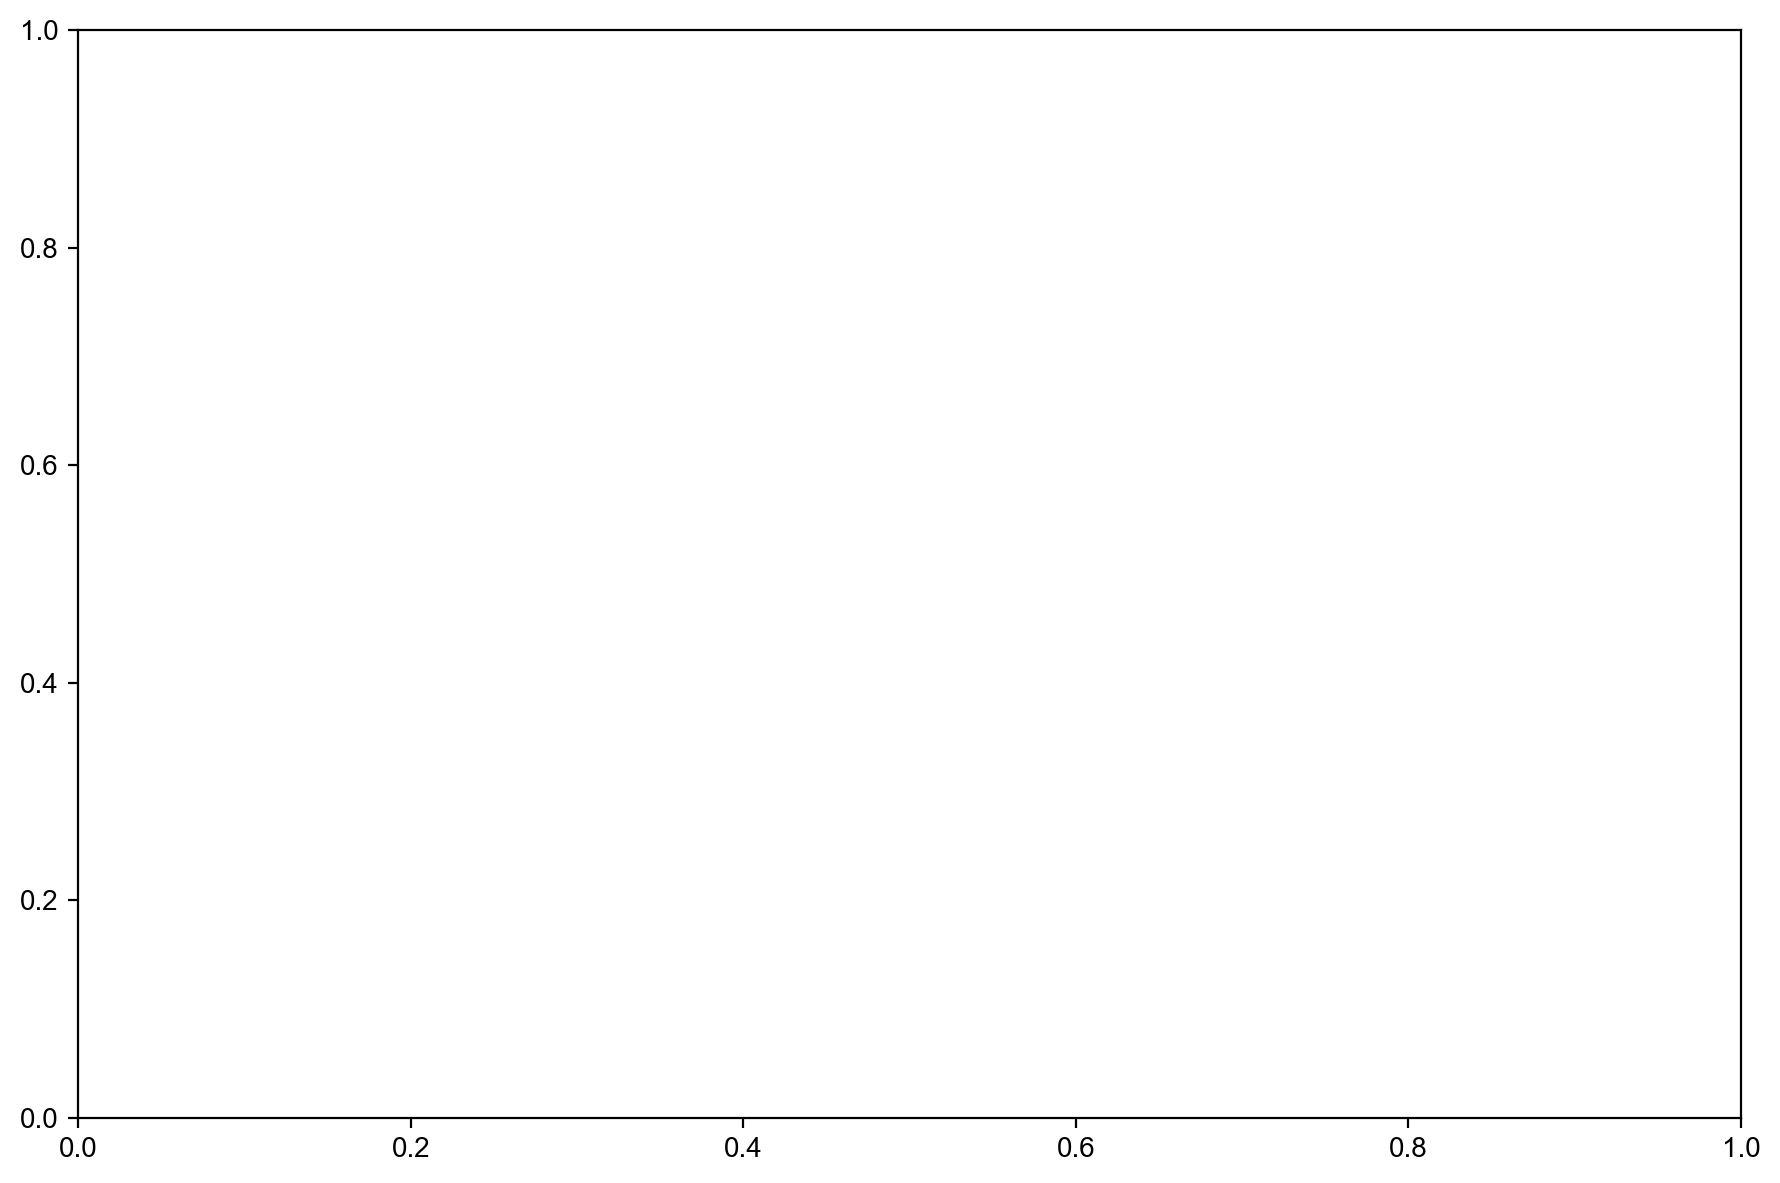

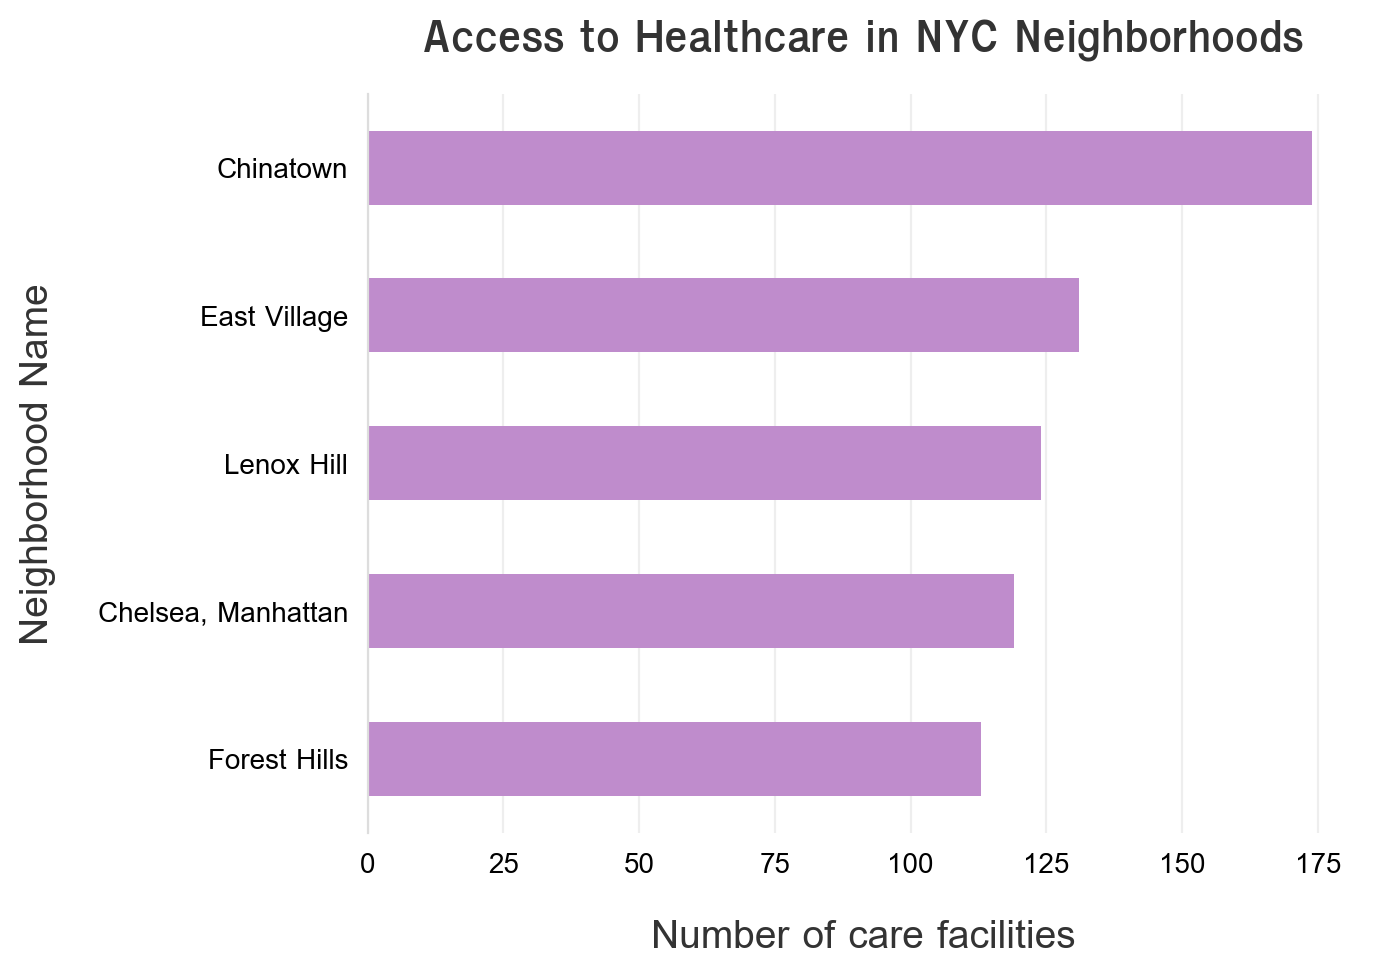

In [164]:
# Initialize fig and axes objects 
f2, ax2 = plt.subplots(figsize=(9,6))

# Plot total number of venues
ax2 = most_venues.head().plot(kind='barh', color=(0.75, 0.55, 0.8, 1))
ax2.invert_yaxis()

# Remove top, right and left spines (borders)
# Also, make the bottom spine gray instead of black.
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_color('#DDDDDD')
ax2.spines['bottom'].set_visible(False)

# Remove axis ticks
ax2.tick_params(bottom=False, left=False)

# Keep the horizontal grid hidden.
# Color the vertical lines as light gray.
ax2.set_axisbelow(True)
ax2.yaxis.grid(False)
ax2.xaxis.grid(True, color='#EEEEEE')
ax2.get_legend().remove()

# Add labels and a title. 
ax2.set_xlabel('Number of care facilities', labelpad=15, color='#333333', fontname='garuda', fontsize=14)
ax2.set_ylabel('Neighborhood Name', labelpad=15, color='#333333', fontname='garuda', fontsize=14)
ax2.set_title('Access to Healthcare in NYC Neighborhoods',loc='center', pad=15, color='#333333',
             weight='bold', fontname='garuda', fontsize=16)

# Make the chart fill out the figure better.
f2.tight_layout()